In [5]:
%cd ..
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt

import json
import numpy as np
import pandas as pd
import sys
sys.path.append(".")

from scripts.models import get_model_cls
from scripts.runner import Runner

from sklearn.preprocessing import StandardScaler

/home/vagrant/Python/projects/ashrae-energy-prediction


In [82]:
class DynpKcpd():
    """Kernel change-point detector.
    """
    def __init__(self, min_size=14, jump=1, max_n_bkps=10):
        self.bkps_candidates = np.arange(0, max_n_bkps).astype(int)
        self.c = rpt.costs.CostRbf()
        self.algo = rpt.Dynp(custom_cost=self.c, min_size=min_size, jump=jump)
        self.min_size = min_size
        self.jump = jump

    def fit(self, y):
        self.algo.fit(y)
        return self

    def predict(self, y, beta=0.3):
        costs = []; bkps = []
        for n_bkps in self.bkps_candidates:
            # calculate for each # of breakpoints
            bkps_hat = self.algo.predict(n_bkps=n_bkps)
            # total segmentation cost
            total_cost = self.algo.cost.sum_of_costs(bkps_hat)
            total_cost /= y.size
            # penalty term
            n = y.shape[0]
            dm = len(bkps_hat)
            pen = beta * dm / n * (np.log(n / dm) + 1)
            total_cost += pen

            costs.append(total_cost)
            bkps.append(bkps_hat)

        best_idx = np.argmin(costs)

        res = dict(
            costs=costs,  # list of total costs including penalty
            bkps=bkps,  # list of break points for each # of segments
            best_n_bkps=best_idx,  # best # of segments
            best_cost = costs[best_idx],  # best total costs including penalty
            best_bkps = bkps[best_idx]  # best break points
        )

        return res

In [2]:
# data loading
train = pd.read_feather("../data/processed/train.feather")
train.index = pd.to_datetime(train["timestamp"])
y = train["meter_reading"]

In [67]:
# aggregate by day
train_agg = train.groupby(["building_id", "meter", pd.Grouper(freq="24h")]).agg(np.median).reset_index()
train_agg.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,0,0,2016-01-02,0.0
2,0,0,2016-01-03,0.0
3,0,0,2016-01-04,0.0
4,0,0,2016-01-05,0.0


In [96]:
BID = 1000
df = train_agg.query(f"building_id == {BID}")
df.tail()

,building_id,meter,timestamp,meter_reading
518112,1000,3,2016-12-27,999.424
518113,1000,3,2016-12-28,649.728
518114,1000,3,2016-12-29,600.065
518115,1000,3,2016-12-30,799.744
518116,1000,3,2016-12-31,600.576


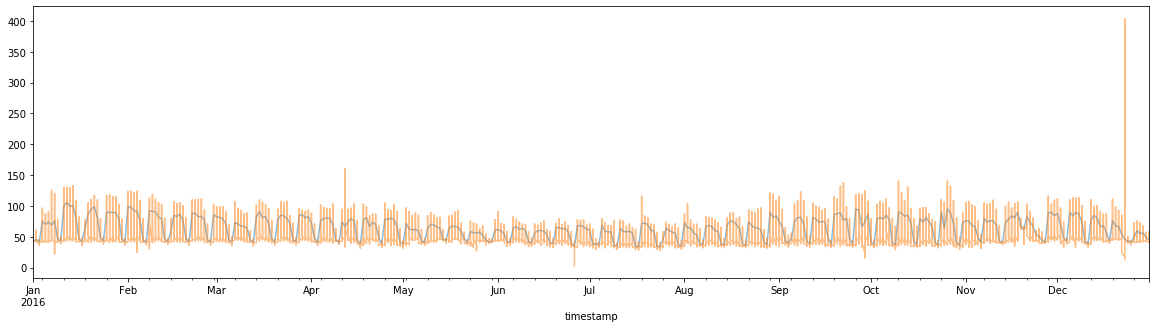

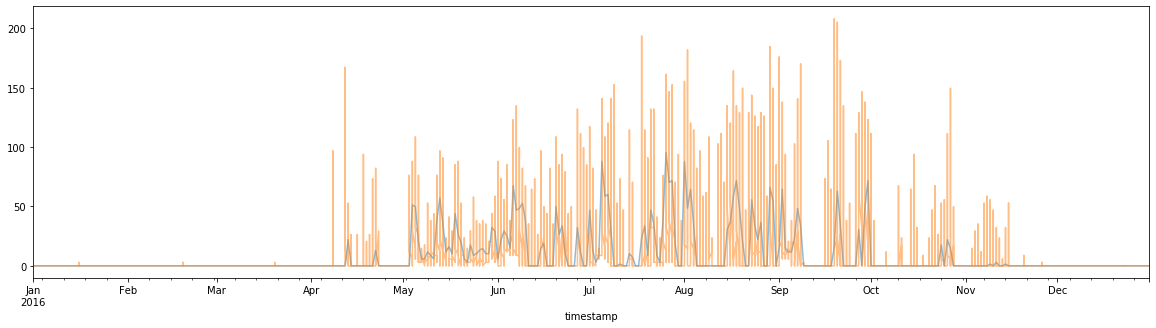

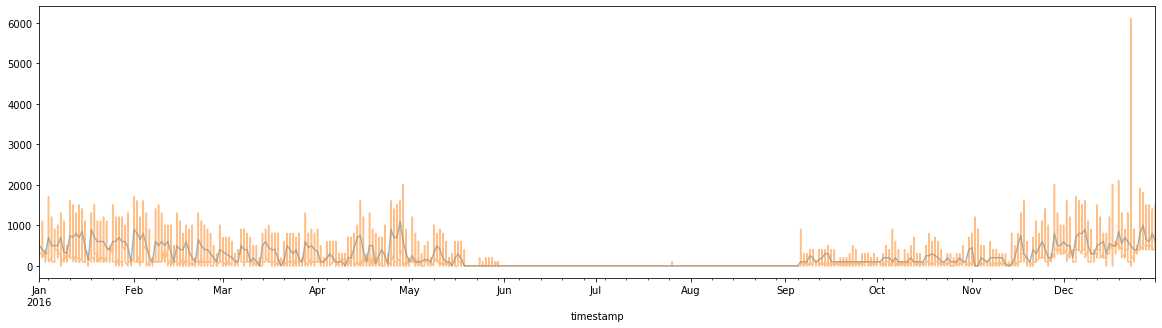

In [97]:
# check if data opertation is correct
for meter in range(df["meter"].unique().size):
    f, ax = plt.subplots(figsize=(20, 5))
    df.pivot(index="timestamp", columns="meter", values="meter_reading").iloc[:, meter].plot(alpha=0.5, ax=ax)
    train.query(f"building_id == {BID}")[["meter_reading", "meter"]].pivot(columns="meter", values="meter_reading").iloc[:, meter].plot(ax=ax, alpha=0.5)

In [ ]:
dfp = df.pivot(index="timestamp", columns="meter", values="meter_reading")
sig = StandardScaler().fit_transform(dfp.values)
print(sig.shape)
kcpd = DynpKcpd().fit(sig)
res = kcpd.predict(sig)

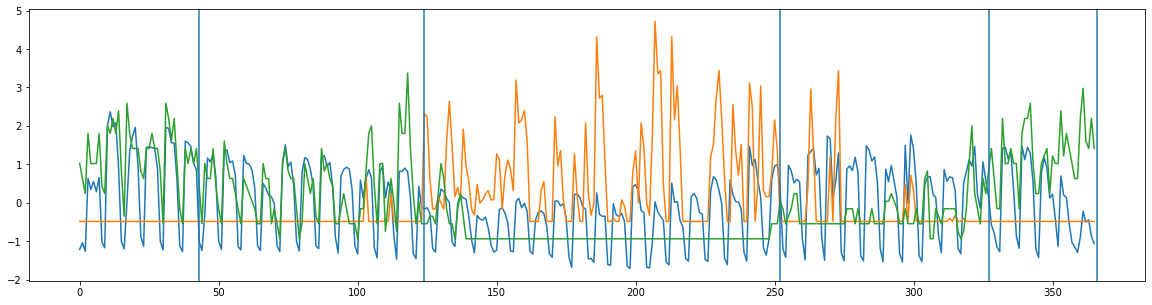

In [217]:
f, ax = plt.subplots(figsize=(20, 5))
ax.plot(sig)
for bkp in res["best_bkps"]:
    ax.axvline(bkp)

## predicted result

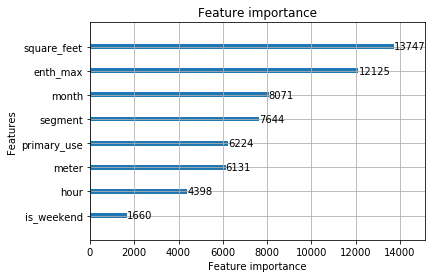

In [60]:
model = load("models/19-11-06_13-37_(segmentation_with_month)-3.model")
import lightgbm as lgb
lgb.plot_importance(model)

In [55]:
import plotly.express as px

In [56]:
from scripts.util import load
yh = np.expm1(load("models/target/19-11-06_13-37_(segmentation_with_month)-train.pkl"))

# data loading
train = pd.read_feather("./data/processed/train.ftr")
train.index = pd.to_datetime(train["timestamp"])
y = train["meter_reading"]

In [57]:
train = train.assign(yh=yh)

In [63]:
bid = 0
b = train.query(f"building_id=={bid}")
b.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,sea_level_pressure,wind_direction,wind_speed,hour,day,month,dayofweek,meter_label,log_meter_reading,yh
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.000000,...,1019.700012,0.0,0.0,0,1,1,4,electricity,0.0,0.124359
2016-01-01 01:00:00,0,0,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN,24.400000,...,1020.200012,70.0,1.5,1,1,1,4,electricity,0.0,0.289769
2016-01-01 02:00:00,0,0,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN,22.799999,...,1020.200012,0.0,0.0,2,1,1,4,electricity,0.0,0.102945
2016-01-01 03:00:00,0,0,2016-01-01 03:00:00,0.0,0,Education,7432,2008.0,NaN,21.100000,...,1020.099976,0.0,0.0,3,1,1,4,electricity,0.0,0.044363
2016-01-01 04:00:00,0,0,2016-01-01 04:00:00,0.0,0,Education,7432,2008.0,NaN,20.000000,...,1020.000000,250.0,2.6,4,1,1,4,electricity,0.0,1.532808


In [64]:
df = b[["timestamp", "meter_label", "meter_reading", "yh"]]\
    .melt(id_vars=["timestamp", "meter_label"],value_vars=["meter_reading", "yh"])
px.line(df, x="timestamp", y="value", color="meter_label", line_dash="variable")